## Bayesian Optimisation Over Molecules
An example notebook for Bayesian optimisation on a molecular dataset using a Tanimoto fingerprint kernel and the photoswitch dataset.$\newline$
Paper: https://pubs.rsc.org/en/content/articlelanding/2022/sc/d2sc04306h $\newline$                                                                                      
Code: https://github.com/Ryan-Rhys/The-Photoswitch-Dataset $\newline$                                                                                                    
This notebook is adapted from https://github.com/leojklarner/gauche/blob/main/notebooks/Bayesian%20Optimisation%20Over%20Molecules.ipynb $\newline$                      
The method of obtaining new data from a discrete dataset is explained in the notebook and the details of the dataset and the method are explained in the code and the paper respectively.

## Imports

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import bofire.strategies.api as strategies
from bofire.benchmarks.data.photoswitches import EXPERIMENTS
from bofire.benchmarks.LookupTableBenchmark import LookupTableBenchmark
from bofire.data_models.acquisition_functions.api import qLogEI
from bofire.data_models.domain.api import Domain, Inputs, Outputs
from bofire.data_models.features.api import CategoricalMolecularInput, ContinuousOutput
from bofire.data_models.molfeatures.api import FingerprintsFragments
from bofire.data_models.objectives.api import MaximizeObjective
from bofire.data_models.strategies.api import RandomStrategy, SoboStrategy
from bofire.data_models.surrogates.api import BotorchSurrogates, TanimotoGPSurrogate
from bofire.runners.api import run


warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")

/opt/homebrew/Caskroom/miniforge/base/envs/bofire-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Benchmark 
input and output feature keys and extract them to get LookUpTable

In [ ]:
benchmark = {
    "input": "SMILES",
    "output": "E isomer pi-pi* wavelength in nm",
}
df = pd.read_json(EXPERIMENTS)
main_file = pd.DataFrame(columns=[benchmark["input"], benchmark["output"]])
nans = df[benchmark["output"]].isnull().to_list()
nan_indices = [nan for nan, x in enumerate(nans) if x]
main_file[benchmark["input"]] = df[benchmark["input"]].drop(nan_indices).to_list()
main_file[benchmark["output"]] = (
    df[benchmark["output"]].dropna().to_numpy().reshape(-1, 1)
)
input_feature = CategoricalMolecularInput(
    key=benchmark["input"],
    categories=list(set(main_file[benchmark["input"]].to_list())),
)
objective = MaximizeObjective(
    w=1.0,
)
inputs = Inputs(features=[input_feature])
output_feature = ContinuousOutput(key=benchmark["output"], objective=objective)
outputs = Outputs(features=[output_feature])
domain = Domain(inputs=inputs, outputs=outputs)

## Random vs SOBO optimization
For molecules, we use Tanimoto GP which has a Tanimoto kernel as default

In [ ]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(20)
    return sampled


def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments[domain.outputs.get_keys()[0]].max()


n_iter = 20 if not SMOKE_TEST else 1
bo_results_set = []
random_results_set = []
n_iterations = 49 if not SMOKE_TEST else 1

for _ in range(n_iter):
    Benchmark = LookupTableBenchmark(domain=domain, lookup_table=main_file)
    sampled = sample(Benchmark.domain)
    sampled_xy = Benchmark.f(sampled, return_complete=True)
    random_results = run(
        Benchmark,
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=n_iterations,
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )

    specs = {Benchmark.domain.inputs.get_keys()[0]: FingerprintsFragments(n_bits=2048)}
    surrogate = TanimotoGPSurrogate(
        inputs=Benchmark.domain.inputs,
        outputs=Benchmark.domain.outputs,
        categorical_encodings=specs,
    )

    def sobo_factory(domain: Domain, surrogate=surrogate):
        return strategies.map(
            SoboStrategy(
                domain=domain,
                acquisition_function=qLogEI(),
                surrogate_specs=BotorchSurrogates(surrogates=[surrogate]),
            ),
        )

    qExpectedImprovement = qLogEI()
    bo_results = run(
        Benchmark,
        strategy_factory=sobo_factory,
        n_iterations=n_iterations,
        metric=best,
        initial_sampler=sampled_xy,
        n_runs=1,
        n_procs=1,
    )
    random_results_new = np.insert(
        random_results[0][1].to_numpy(),
        0,
        best(Benchmark.domain, sampled_xy),
    )
    bo_results_new = np.insert(
        bo_results[0][1].to_numpy(),
        0,
        best(Benchmark.domain, sampled_xy),
    )
    random_results_set.append(random_results_new)
    bo_results_set.append(bo_results_new)

  0%|          | 0/49 [00:00<?, ?it/s]

Run 0: 100%|██████████| 49/49 [01:06<00:00,  1.35s/it, Current Best:=623.000]


## Performance
SOBO outperforms random search in terms of selecting molecules with high E isomer pi-pi* transition wavelength.

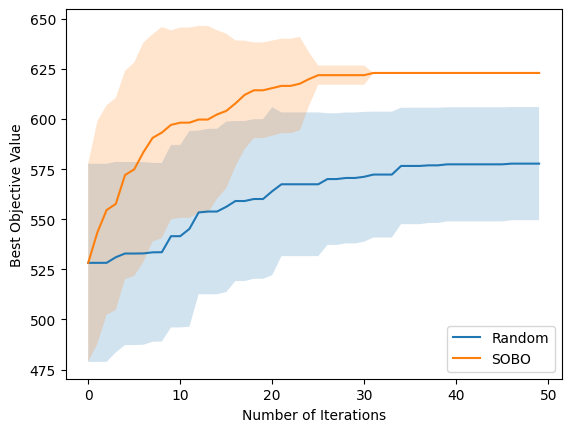

In [ ]:
# Define a confience interval function for plotting.
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(n_iter)


if not SMOKE_TEST:
    iters = np.arange(n_iterations + 1)
    y_rnd = np.asarray(random_results_set)
    y_ei = np.asarray(bo_results_set)

    y_rnd_mean = y_rnd.mean(axis=0)
    y_ei_mean = y_ei.mean(axis=0)
    y_rnd_std = y_rnd.std(axis=0)
    y_ei_std = y_ei.std(axis=0)

    lower_rnd = y_rnd_mean - y_rnd_std
    upper_rnd = y_rnd_mean + y_rnd_std
    lower_ei = y_ei_mean - y_ei_std
    upper_ei = y_ei_mean + y_ei_std

    plt.plot(iters, y_rnd_mean, label="Random")
    plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2)
    plt.plot(iters, y_ei_mean, label="SOBO")
    plt.fill_between(iters, lower_ei, upper_ei, alpha=0.2)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Best Objective Value")
    plt.legend(loc="lower right")
    plt.show()